### Data exploration and preprocessing for the [...] dataset

In [1]:
"""
Load the source dataset and preprocess it

__ imgs
    |
    |__ fold_1
          |__ datasetname_id.png --> images
          |__ ...
    |__ fold_2
          |__ datasetname_id.png
          |__ ...
    |__ fold_3
          |__ datasetname_id.png
          |__ ...
    |__ fold_4
          |__ datasetname_id.png
          |__ ...
    |__ fold_5
          |__ datasetname_id.png
          |__ ...

__ masks
    |
    |__ fold_1
          |__ datasetname_id.png  --> segmentation mask
          |__ ...
    |__ fold_2
          |__ datasetname_id.png
          |__ ...
    |__ fold_3
          |__ datasetname_id.png
          |__ ...
    |__ fold_4
          |__ datasetname_id.png
          |__ ...
    |__ fold_5
          |__ datasetname_id.png
          |__ ...

For segmentation masks --> 0 and 1 (if more than 2 labels --> use SimpleITK to encode integers in images)
"""

'\nLoad the source dataset and preprocess it\n\n__ imgs\n    |\n    |__ fold_1\n          |__ datasetname_id.png --> images\n          |__ ...\n    |__ fold_2\n          |__ datasetname_id.png\n          |__ ...\n    |__ fold_3\n          |__ datasetname_id.png\n          |__ ...\n    |__ fold_4\n          |__ datasetname_id.png\n          |__ ...\n    |__ fold_5\n          |__ datasetname_id.png\n          |__ ...\n\n__ masks\n    |\n    |__ fold_1\n          |__ datasetname_id.png  --> segmentation mask\n          |__ ...\n    |__ fold_2\n          |__ datasetname_id.png\n          |__ ...\n    |__ fold_3\n          |__ datasetname_id.png\n          |__ ...\n    |__ fold_4\n          |__ datasetname_id.png\n          |__ ...\n    |__ fold_5\n          |__ datasetname_id.png\n          |__ ...\n\nFor segmentation masks --> 0 and 1 (if more than 2 labels --> use SimpleITK to encode integers in images)\n'

In [4]:
import os
import zipfile
import random
import shutil
from PIL import Image
from tqdm import tqdm
import json 
import subprocess
from pycocotools import mask as coco_mask
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

from helpers import check_dir_consistency, visualize_images, get_all_dims, create_histograms_of_dims

### Download the dataset and its annotations

In [5]:
seed = 42

In [6]:
data_source_dir = '/home/rob/Documents/3_projects/bench/coco/data' # <--- modify this
output_dir = '/home/rob/Documents/3_projects/bench/coco/output' # <--- modify this
tmp_data_dir = os.path.join(output_dir, 'tmp_data')

skip_dl = True
needs_unzip = False
needs_data_copy = False
[os.makedirs(dir, exist_ok=True) for dir in [data_source_dir, output_dir, tmp_data_dir]]

[None, None, None]

In [7]:
if skip_dl is False and len(os.listdir(data_source_dir)) == 0:
    # Download source directories
    subprocess.run(['wget', '-P', data_source_dir, 'http://images.cocodataset.org/zips/val2017.zip', '-O', os.path.join(data_source_dir, 'coco_val2017.zip')])
    subprocess.run(['wget', '-P', data_source_dir, 'http://images.cocodataset.org/zips/train2017.zip', '-O', os.path.join(data_source_dir, 'coco_train2017.zip')])
    subprocess.run(['wget', '-P', data_source_dir, 'http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip', '-O', os.path.join(data_source_dir, 'stuff_annotations_trainval2017.zip')])
else:
    print(f'Skipping download.')

Skipping download.


In [8]:
data_sources = [os.path.join(data_source_dir, f) for f in os.listdir(data_source_dir)]
data_sources

['/home/rob/Documents/3_projects/bench/coco/data/coco_val2017.zip',
 '/home/rob/Documents/3_projects/bench/coco/data/stuff_annotations_trainval2017.zip',
 '/home/rob/Documents/3_projects/bench/coco/data/coco_train2017.zip']

In [9]:
# Unzip downloaded directories
def unzip_dirs(data_sources: str, tmp_data_dir: str) -> list:
    subdirs: list = []

    for data_source in tqdm(data_sources, desc='Unzip dir'):
        subdir_name = os.path.splitext(os.path.basename(data_source))[0]
        subdir_path = os.path.join(tmp_data_dir, subdir_name)
        subdirs.append(subdir_path)

        # Make destination dir
        os.makedirs(subdir_path, exist_ok=True)
        
        # Unzip
        with zipfile.ZipFile(data_source, 'r') as zip_file:
            print(f'Unzipping {data_source} into {subdir_path}')
            zip_file.extractall(subdir_path)

    return subdirs

if needs_unzip:
    subdirs = unzip_dirs(data_sources, tmp_data_dir)

In [10]:
annotations_dir = os.path.join(tmp_data_dir, 'stuff_annotations_trainval2017/annotations')
annotations_train = os.path.join(annotations_dir, 'stuff_train2017.json')
annotations_val = os.path.join(annotations_dir, 'stuff_val2017.json')

## Only use Train Data and make 5 folds from them

In [11]:
img_source_dir = os.path.join(tmp_data_dir, 'coco_train2017', 'train2017')

In [12]:
all_dims = get_all_dims(img_source_dir)
all_dims

Number of unique dimensions in images: 2477


{(438, 640),
 (320, 239),
 (500, 435),
 (640, 329),
 (238, 206),
 (610, 423),
 (576, 430),
 (312, 500),
 (500, 471),
 (580, 580),
 (640, 594),
 (446, 500),
 (338, 409),
 (255, 640),
 (336, 448),
 (640, 185),
 (380, 640),
 (500, 327),
 (640, 450),
 (263, 500),
 (640, 221),
 (358, 243),
 (468, 640),
 (550, 413),
 (200, 300),
 (400, 325),
 (593, 640),
 (320, 216),
 (574, 361),
 (640, 306),
 (476, 500),
 (475, 355),
 (360, 288),
 (500, 448),
 (640, 571),
 (640, 342),
 (640, 607),
 (324, 487),
 (500, 304),
 (418, 500),
 (640, 198),
 (450, 303),
 (640, 463),
 (411, 640),
 (379, 279),
 (357, 520),
 (500, 160),
 (392, 218),
 (450, 339),
 (300, 480),
 (400, 338),
 (360, 265),
 (500, 425),
 (285, 500),
 (490, 640),
 (640, 319),
 (425, 251),
 (640, 584),
 (364, 500),
 (251, 480),
 (500, 281),
 (498, 500),
 (441, 640),
 (640, 440),
 (315, 500),
 (520, 640),
 (392, 640),
 (500, 402),
 (640, 296),
 (618, 394),
 (610, 390),
 (575, 432),
 (594, 445),
 (500, 438),
 (640, 561),
 (471, 640),
 (612, 499),

In [13]:
def plot_unique_dims(dimensions):
    x_values = [dim[0] for dim in dimensions]
    y_values = [dim[1] for dim in dimensions]

    # Création du scatter plot
    plt.scatter(x_values, y_values)
    plt.title("Unique Image Dimensions (Width x Height)")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.grid(True)
    plt.show()

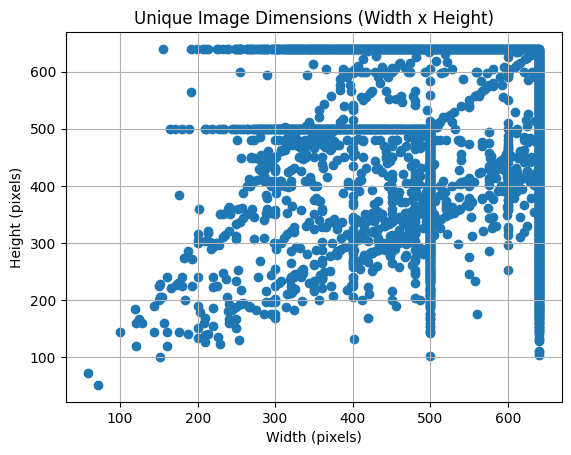

In [14]:
plot_unique_dims(all_dims)

In [15]:
min_width = min(dim[0] for dim in all_dims)
min_height = min(dim[1] for dim in all_dims)
max_width = max(dim[0] for dim in all_dims)
max_height = max(dim[1] for dim in all_dims)
print(f"Minimum width: {min_width} | max width: {max_width}")
print(f"Minimum height: {min_height} | max height: {max_height}")

Minimum width: 59 | max width: 640
Minimum height: 51 | max height: 640


In [16]:
print(img_source_dir)

/home/rob/Documents/3_projects/bench/coco/output/tmp_data/coco_train2017/train2017


In [17]:
train_masks_dir = os.path.join(tmp_data_dir, 'stuff_annotations_trainval2017', 'annotations', 'stuff_train2017_pixelmaps.zip')
valid_masks_dir = os.path.join(tmp_data_dir, 'stuff_annotations_trainval2017', 'annotations', 'stuff_val2017_pixelmaps.zip')

In [18]:
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Finished extracting: {zip_path}")

In [19]:
if needs_unzip:
    extract_zip(train_masks_dir, tmp_data_dir)

In [20]:
if needs_unzip:
    extract_zip(valid_masks_dir, tmp_data_dir)

In [21]:
unziped_train_masks_dir = os.path.join(tmp_data_dir, 'stuff_train2017_pixelmaps')
unziped_valid_masks_dir = os.path.join(tmp_data_dir, 'stuff_val2017_pixelmaps')

## Get Train images

In [22]:
imgs_dir = os.path.join(tmp_data_dir, 'imgs')
os.makedirs(imgs_dir, exist_ok=True)

In [ ]:
# valid_masks_files = set(os.listdir(unziped_valid_masks_dir))

In [ ]:
# len(valid_masks_files)

In [24]:
if needs_data_copy:
    for img_file in tqdm(os.listdir(img_source_dir)):
        src_path = os.path.join(img_source_dir, img_file)
        dest_path = os.path.join(imgs_dir, img_file)
        shutil.copy(src_path, dest_path)

## Get Train masks

In [25]:
masks_dir = os.path.join(tmp_data_dir, 'masks')
os.makedirs(masks_dir, exist_ok=True)

In [26]:
if needs_data_copy:
    for img_file in tqdm(os.listdir(unziped_train_masks_dir)):
        src_path = os.path.join(unziped_train_masks_dir, img_file)
        dest_path = os.path.join(masks_dir, img_file)
        shutil.copy(src_path, dest_path)

In [27]:
print(imgs_dir)

/home/rob/Documents/3_projects/bench/coco/output/tmp_data/imgs


In [28]:
print(masks_dir)

/home/rob/Documents/3_projects/bench/coco/output/tmp_data/masks


In [29]:
img_files = os.listdir(imgs_dir)

mask_files = os.listdir(masks_dir)
print(len(img_files) == len(mask_files))

True


In [30]:
result = check_dir_consistency(imgs_dir, masks_dir)
result

Mask corresponding to image `000000083178.jpg` was not found.
Mask corresponding to image `000000440903.jpg` was not found.
Mask corresponding to image `000000470658.jpg` was not found.
Mask corresponding to image `000000389491.jpg` was not found.
Mask corresponding to image `000000138595.jpg` was not found.
Mask corresponding to image `000000455717.jpg` was not found.
Mask corresponding to image `000000265010.jpg` was not found.
Mask corresponding to image `000000384780.jpg` was not found.
Mask corresponding to image `000000120357.jpg` was not found.
Mask corresponding to image `000000198162.jpg` was not found.
Mask corresponding to image `000000282949.jpg` was not found.
Mask corresponding to image `000000325154.jpg` was not found.
Mask corresponding to image `000000541782.jpg` was not found.
Mask corresponding to image `000000318240.jpg` was not found.
Mask corresponding to image `000000354639.jpg` was not found.
Mask corresponding to image `000000106168.jpg` was not found.
Mask cor

KeyboardInterrupt: 

## Finally, move to imgs and masks output dir

In [34]:
output_dir_imgs = os.path.join(output_dir, 'imgs')
os.makedirs(output_dir_imgs, exist_ok=True)

output_dir_masks = os.path.join(output_dir, 'masks')
os.makedirs(output_dir_masks, exist_ok=True)

In [50]:
def create_folds_and_split_data(img_folder: str, mask_folder: str, output_dir: str, seed: int = 42, n_folds: int = 5):
    # 0. Set random seed
    np.random.seed(seed)
    
    # 1. Create folder structure
    img_output_dir = os.path.join(output_dir, 'imgs')
    mask_output_dir = os.path.join(output_dir, 'masks')

    for i in range(0, n_folds):
        os.makedirs(os.path.join(img_output_dir, f'fold_{i}'), exist_ok=True)
        os.makedirs(os.path.join(mask_output_dir, f'fold_{i}'), exist_ok=True)

    # 2. Shuffle and split images and masks
    img_files = sorted(os.listdir(img_folder))
    np.random.shuffle(img_files)

    fold_size = len(img_files) // n_folds
    print(f'Size of fold: {fold_size}')

    for i, img_file in tqdm(enumerate(img_files)):
        fold_num = (i // fold_size)
        if fold_num > n_folds - 1:  # Avoid additional fold with fewer images
            fold_num = n_folds - 1
            
        # 3. Copy files
        img_src = os.path.join(img_folder, img_file)
        img_dst = os.path.join(img_output_dir, f'fold_{fold_num}', img_file)
        shutil.copy(img_src, img_dst)

        # Copy corresponding mask
        mask_file = img_file.split('.')[0] + '.png'
        mask_src = os.path.join(mask_folder, mask_file)

        mask_dst = os.path.join(mask_output_dir, f'fold_{fold_num}', mask_file)
        shutil.copy(mask_src, mask_dst)
    
    return img_output_dir, mask_output_dir


In [51]:
img_output_dir, mask_output_dir = create_folds_and_split_data(imgs_dir, masks_dir, output_dir, seed)

Size of fold: 23657


164it [00:00, 1635.60it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

495it [00:00, 1644.47it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

847it [00:00, 1700.62it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

1185it [00:00, 1625.21it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

1510it [00:00, 1576.08it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

1818it [00:01, 1443.14it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

2100it [00:01, 1276.80it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

2374it [00:01, 1318.69it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

2507it [00:01, 1321.49it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

2771it [00:01, 1292.20it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

3043it [00:02, 1297.47it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

3325it [00:02, 1349.95it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

3594it [00:02, 1306.08it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

3859it [00:02, 1297.17it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

4130it [00:02, 1325.81it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

4399it [00:03, 1321.92it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

4656it [00:03, 1218.79it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

4925it [00:03, 1282.25it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

5201it [00:03, 1284.14it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

5459it [00:03, 1278.12it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

5721it [00:04, 1283.50it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

5981it [00:04, 1261.64it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

6271it [00:04, 1349.63it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

6551it [00:04, 1375.24it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

6834it [00:05, 1372.71it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

7109it [00:05, 1330.25it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

7390it [00:05, 1367.83it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

7678it [00:05, 1401.69it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

7959it [00:05, 1342.02it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

8094it [00:05, 1319.99it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

8358it [00:06, 1299.32it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

8631it [00:06, 1301.79it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

8901it [00:06, 1205.07it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

9141it [00:06, 1113.40it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

9399it [00:07, 1200.77it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

9657it [00:07, 1218.05it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

9907it [00:07, 1207.74it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

10177it [00:07, 1280.84it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

10442it [00:07, 1292.37it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

10709it [00:08, 1290.62it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

10980it [00:08, 1322.30it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

11113it [00:08, 1251.46it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

11367it [00:08, 1248.32it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

11631it [00:08, 1286.19it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

11888it [00:08, 1264.79it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

12152it [00:09, 1293.08it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

12421it [00:09, 1287.42it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

12708it [00:09, 1367.86it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

12982it [00:09, 1318.54it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

13269it [00:10, 1370.24it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

13572it [00:10, 1445.42it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

13873it [00:10, 1476.29it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

14166it [00:10, 1387.99it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

14462it [00:10, 1429.70it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

14763it [00:11, 1460.18it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

15068it [00:11, 1491.31it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

15369it [00:11, 1481.79it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

15675it [00:11, 1499.58it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

15974it [00:11, 1463.89it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

16271it [00:12, 1471.56it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

16567it [00:12, 1458.67it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

16865it [00:12, 1454.51it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

17170it [00:12, 1475.95it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

17472it [00:12, 1488.02it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

17766it [00:13, 1398.77it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

18057it [00:13, 1409.74it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

18354it [00:13, 1440.11it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

18648it [00:13, 1454.02it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

18794it [00:13, 1445.54it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

19098it [00:14, 1472.54it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

19401it [00:14, 1492.58it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

19708it [00:14, 1505.99it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

20011it [00:14, 1494.69it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

20312it [00:14, 1482.06it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

20623it [00:15, 1516.26it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

20934it [00:15, 1479.18it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

21235it [00:15, 1430.38it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

21522it [00:15, 1407.85it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

21815it [00:15, 1417.03it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

22114it [00:16, 1458.07it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

22407it [00:16, 1412.22it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

22703it [00:16, 1443.88it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

22995it [00:16, 1438.15it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

23288it [00:16, 1447.77it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

23586it [00:17, 1462.46it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold

23876it [00:17, 1396.35it/s]

fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 0
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

24172it [00:17, 1434.72it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

24472it [00:17, 1468.22it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

24772it [00:17, 1466.96it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

25062it [00:18, 1410.95it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

25352it [00:18, 1426.26it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

25641it [00:18, 1412.26it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

25933it [00:18, 1436.32it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

26228it [00:18, 1449.08it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

26533it [00:19, 1483.68it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

26682it [00:19, 1478.42it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

26975it [00:19, 1432.63it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

27266it [00:19, 1438.88it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

27563it [00:19, 1459.21it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

27853it [00:20, 1435.14it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

28158it [00:20, 1475.14it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

28445it [00:20, 1317.62it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

28741it [00:20, 1389.57it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

29038it [00:20, 1421.27it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

29336it [00:21, 1454.48it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

29644it [00:21, 1490.08it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

29939it [00:21, 1422.22it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

30226it [00:21, 1407.75it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

30519it [00:21, 1402.66it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

30815it [00:22, 1438.58it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

31103it [00:22, 1421.76it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

31410it [00:22, 1480.35it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

31567it [00:22, 1504.98it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

31861it [00:22, 1328.42it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

32165it [00:23, 1415.46it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

32468it [00:23, 1464.28it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

32770it [00:23, 1464.51it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

33065it [00:23, 1450.77it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

33359it [00:23, 1425.89it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

33650it [00:24, 1329.18it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

33962it [00:24, 1439.17it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

34272it [00:24, 1494.73it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

34579it [00:24, 1511.67it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

34892it [00:24, 1520.59it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

35203it [00:25, 1518.56it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

35517it [00:25, 1502.37it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

35668it [00:25, 1468.46it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

35953it [00:25, 1228.28it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

36199it [00:25, 1131.04it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

36426it [00:26, 1095.45it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

36687it [00:26, 1210.75it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

36978it [00:26, 1323.59it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

37272it [00:26, 1393.10it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

37576it [00:27, 1459.52it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

37876it [00:27, 1471.34it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

38171it [00:27, 1453.87it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

38466it [00:27, 1459.89it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

38613it [00:27, 1417.95it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

38919it [00:27, 1421.37it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

39213it [00:28, 1439.81it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

39527it [00:28, 1502.37it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

39846it [00:28, 1549.58it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

40156it [00:28, 1528.52it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

40480it [00:28, 1576.72it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

40805it [00:29, 1587.98it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

41140it [00:29, 1635.47it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

41488it [00:29, 1688.49it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

41826it [00:29, 1670.88it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

42154it [00:29, 1566.31it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

42465it [00:30, 1510.68it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

42774it [00:30, 1519.17it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

43091it [00:30, 1552.07it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

43400it [00:30, 1517.51it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

43704it [00:31, 1505.83it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

44010it [00:31, 1489.77it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

44318it [00:31, 1482.88it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

44620it [00:31, 1477.88it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

44919it [00:31, 1454.37it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

45065it [00:31, 1320.70it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

45353it [00:32, 1333.45it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

45662it [00:32, 1435.61it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

45963it [00:32, 1472.23it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

46259it [00:32, 1437.09it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

46558it [00:33, 1466.13it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

46856it [00:33, 1474.56it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

47153it [00:33, 1469.10it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold

47448it [00:33, 1447.85it/s]

fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 1
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

47737it [00:33, 1420.13it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

48040it [00:34, 1452.57it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

48341it [00:34, 1458.34it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

48641it [00:34, 1466.41it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

48940it [00:34, 1466.36it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

49237it [00:34, 1473.53it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

49530it [00:35, 1446.74it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

49819it [00:35, 1410.88it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

50103it [00:35, 1370.58it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

50397it [00:35, 1400.40it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

50684it [00:35, 1375.29it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

50960it [00:36, 1368.66it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

51271it [00:36, 1459.87it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

51569it [00:36, 1473.97it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

51867it [00:36, 1470.08it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

52015it [00:36, 1457.23it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

52306it [00:37, 1409.33it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

52595it [00:37, 1407.76it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

52888it [00:37, 1418.49it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

53170it [00:37, 1314.91it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

53451it [00:37, 1332.01it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

53741it [00:38, 1391.06it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

54034it [00:38, 1346.95it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

54318it [00:38, 1346.51it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

54608it [00:38, 1393.53it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

54897it [00:38, 1409.12it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

55039it [00:38, 1401.14it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

55319it [00:39, 1338.45it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

55590it [00:39, 1309.28it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

55867it [00:39, 1348.53it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

56162it [00:39, 1398.24it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

56464it [00:40, 1430.84it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

56775it [00:40, 1492.90it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

57081it [00:40, 1402.56it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

57382it [00:40, 1443.44it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

57684it [00:40, 1476.06it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

57982it [00:41, 1459.03it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

58284it [00:41, 1485.24it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

58593it [00:41, 1509.82it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

58894it [00:41, 1480.82it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

59191it [00:41, 1392.34it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

59332it [00:42, 1248.18it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

59581it [00:42, 1140.15it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

59808it [00:42, 1081.75it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

60026it [00:42, 1054.00it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

60311it [00:42, 1231.78it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

60605it [00:43, 1338.47it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

60887it [00:43, 1375.38it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

61184it [00:43, 1431.33it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

61337it [00:43, 1458.68it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

61627it [00:43, 1407.44it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

61923it [00:44, 1442.27it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

62215it [00:44, 1447.60it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

62504it [00:44, 1430.62it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

62805it [00:44, 1425.33it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

63104it [00:44, 1413.42it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

63407it [00:45, 1439.81it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

63701it [00:45, 1447.71it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

64007it [00:45, 1484.98it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

64303it [00:45, 1430.71it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

64610it [00:45, 1483.77it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

64908it [00:46, 1468.74it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

65203it [00:46, 1447.21it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

65518it [00:46, 1511.66it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

65823it [00:46, 1503.58it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

66127it [00:46, 1499.83it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

66426it [00:47, 1466.12it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

66726it [00:47, 1475.89it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

67194it [00:47, 1913.72it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

67686it [00:47, 2203.01it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

68165it [00:47, 2052.25it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

68375it [00:48, 1888.52it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

68752it [00:48, 1705.11it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

68926it [00:48, 1652.69it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

69256it [00:48, 1590.41it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

69573it [00:48, 1552.78it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

69880it [00:49, 1480.71it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

70176it [00:49, 1450.81it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

70474it [00:49, 1467.65it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

70772it [00:49, 1454.37it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

71081it [00:49, 1497.10it/s]

fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold num: 2
fold

71385it [00:50, 1500.04it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

71694it [00:50, 1511.09it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

72001it [00:50, 1496.16it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

72300it [00:50, 1456.89it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

72614it [00:50, 1509.38it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

72931it [00:51, 1518.47it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

73084it [00:51, 1354.84it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

73377it [00:51, 1383.61it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

73692it [00:51, 1472.81it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

73988it [00:51, 1454.61it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

74295it [00:52, 1491.00it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

74602it [00:52, 1484.69it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

74902it [00:52, 1486.24it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

75202it [00:52, 1462.67it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

75507it [00:52, 1493.29it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

75811it [00:53, 1493.37it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

76119it [00:53, 1505.38it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

76437it [00:53, 1547.45it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

76747it [00:53, 1539.55it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

77053it [00:53, 1502.45it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

77353it [00:54, 1481.39it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

77655it [00:54, 1463.25it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

77947it [00:54, 1393.69it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

78242it [00:54, 1430.27it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

78542it [00:55, 1464.51it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

78853it [00:55, 1509.86it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

79158it [00:55, 1509.76it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

79473it [00:55, 1534.90it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

79783it [00:55, 1529.61it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

79937it [00:55, 1440.39it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

80225it [00:56, 1385.91it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

80531it [00:56, 1458.57it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

80840it [00:56, 1500.61it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

81143it [00:56, 1496.91it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

81451it [00:56, 1498.79it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

81761it [00:57, 1479.65it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

82060it [00:57, 1475.04it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

82360it [00:57, 1380.14it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

82657it [00:57, 1427.25it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

82943it [00:58, 1387.44it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

83240it [00:58, 1434.84it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

83543it [00:58, 1472.01it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

83850it [00:58, 1505.06it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

84152it [00:58, 1506.44it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

84303it [00:58, 1502.87it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

84591it [00:59, 1245.52it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

84840it [00:59, 1144.57it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

85068it [00:59, 1084.61it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

85322it [00:59, 1157.15it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

85619it [01:00, 1311.42it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

85907it [01:00, 1362.35it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

86199it [01:00, 1411.00it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

86498it [01:00, 1445.65it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

86644it [01:00, 1448.91it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

86940it [01:00, 1433.57it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

87239it [01:01, 1462.13it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

87551it [01:01, 1513.45it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

87855it [01:01, 1508.76it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

88161it [01:01, 1513.80it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

88470it [01:01, 1514.56it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

88779it [01:02, 1522.99it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

89091it [01:02, 1522.29it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

89401it [01:02, 1523.09it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

89709it [01:02, 1499.53it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

90018it [01:03, 1522.09it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

90327it [01:03, 1529.24it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

90634it [01:03, 1493.16it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

90939it [01:03, 1503.54it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

91245it [01:03, 1476.78it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

91541it [01:04, 1451.17it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

91842it [01:04, 1463.45it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

92139it [01:04, 1468.80it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

92438it [01:04, 1479.16it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

92734it [01:04, 1473.26it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

93041it [01:05, 1501.86it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

93342it [01:05, 1498.10it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

93646it [01:05, 1467.51it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

93952it [01:05, 1496.57it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

94251it [01:05, 1464.15it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

94545it [01:06, 1452.32it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold

94842it [01:06, 1449.87it/s]

fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 3
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

95149it [01:06, 1495.30it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

95450it [01:06, 1491.59it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

95756it [01:06, 1460.42it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

95903it [01:07, 1352.64it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

96170it [01:07, 1196.61it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

96471it [01:07, 1338.68it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

96767it [01:07, 1405.34it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

97069it [01:07, 1446.61it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

97358it [01:08, 1418.07it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

97648it [01:08, 1424.59it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

97946it [01:08, 1456.95it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

98249it [01:08, 1474.70it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

98555it [01:08, 1500.50it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

98863it [01:09, 1491.93it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

99167it [01:09, 1501.53it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

99477it [01:09, 1527.61it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

99781it [01:09, 1501.14it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

100087it [01:09, 1501.99it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

100391it [01:10, 1479.30it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

100688it [01:10, 1446.54it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

100979it [01:10, 1442.52it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

101295it [01:10, 1505.80it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

101610it [01:10, 1542.70it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

101919it [01:11, 1518.30it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

102235it [01:11, 1545.04it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

102541it [01:11, 1478.84it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

102690it [01:11, 1470.58it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

102978it [01:11, 1359.71it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

103279it [01:12, 1427.38it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

103570it [01:12, 1439.32it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

103862it [01:12, 1438.04it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

104147it [01:12, 1363.48it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

104453it [01:12, 1441.59it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

104753it [01:13, 1470.31it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

105051it [01:13, 1466.87it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

105347it [01:13, 1445.23it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

105648it [01:13, 1475.85it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

105940it [01:13, 1300.39it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

106229it [01:14, 1362.64it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

106525it [01:14, 1419.69it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

106848it [01:14, 1514.89it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

107005it [01:14, 1530.48it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

107306it [01:14, 1380.32it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

107582it [01:15, 1288.13it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

107712it [01:15, 1184.56it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

107945it [01:15, 1058.95it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

108158it [01:15, 1024.46it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

108364it [01:15, 996.09it/s] 

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

108602it [01:16, 1102.50it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

108868it [01:16, 1218.08it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

109172it [01:16, 1366.27it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

109476it [01:16, 1440.68it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

109783it [01:16, 1485.33it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

110084it [01:17, 1466.32it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

110384it [01:17, 1474.43it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

110675it [01:17, 1393.02it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

110964it [01:17, 1418.01it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

111256it [01:18, 1418.08it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

111548it [01:18, 1438.74it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

111853it [01:18, 1480.78it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

112162it [01:18, 1511.75it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

112471it [01:18, 1490.41it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

112771it [01:19, 1464.64it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

112918it [01:19, 1432.34it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

113213it [01:19, 1417.35it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

113511it [01:19, 1449.76it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

113800it [01:19, 1346.48it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

114062it [01:20, 1242.38it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

114367it [01:20, 1376.96it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

114679it [01:20, 1465.79it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

114980it [01:20, 1468.78it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

115287it [01:20, 1497.55it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

115438it [01:20, 1446.18it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

115733it [01:21, 1426.09it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

116190it [01:21, 1479.55it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

116339it [01:21, 1431.62it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

116638it [01:21, 1413.24it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

116923it [01:21, 1403.65it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

117219it [01:22, 1438.52it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

117508it [01:22, 1406.85it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

117803it [01:22, 1441.61it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

118104it [01:22, 1471.73it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold

118287it [01:22, 1426.68it/s]

fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 4
fold num: 5
fold num: 5


In [58]:
[len(os.listdir(os.path.join(output_dir, f'masks/fold_{i}'))) for i in range(5)]

[23657, 23657, 23657, 23657, 23659]

In [59]:
len(os.listdir(os.path.join(output_dir, 'masks/fold_4')))

23659

In [48]:
def verify_image_mask_correspondence(output_dir, img_folder, mask_folder, n_folds=5):
    """
    Verify that every image in each fold has a corresponding mask and vice versa,
    and that the total count of images and masks matches the original dataset.

    Args:
    output_dir (str): The base directory where the 'imgs' and 'masks' subdirectories are located.
    img_folder (str): The directory containing the original images.
    mask_folder (str): The directory containing the original masks.
    n_folds (int): Number of folds to check for correspondence.

    Raises:
    Exception: If an image doesn't have a corresponding mask, a mask doesn't have a corresponding image,
               or the total count of images and masks doesn't match the original dataset.

    Returns:
    bool: True if all tests pass, False otherwise.
    """
    img_output_dir = os.path.join(output_dir, 'imgs')
    mask_output_dir = os.path.join(output_dir, 'masks')
    original_img_count = len(os.listdir(img_folder))
    original_mask_count = len(os.listdir(mask_folder))
    
    total_img_count = 0
    total_mask_count = 0

    for i in tqdm(range(0, n_folds)):
        img_fold_dir = os.path.join(img_output_dir, f'fold_{i}')
        mask_fold_dir = os.path.join(mask_output_dir, f'fold_{i}')

        img_files = set(os.listdir(img_fold_dir))
        img_files_no_ext = [img_file.split('.')[0] for img_file in img_files]

        mask_files = set(os.listdir(mask_fold_dir))
        mask_files_no_ext = [img_file.split('.')[0] for img_file in img_files]

        total_img_count += len(img_files)
        total_mask_count += len(mask_files)

        # Test 1: Each image has a corresponding mask
        for img_file in img_files_no_ext:
            if img_file not in mask_files_no_ext:
                raise Exception(f"Image {img_file} in fold_{i} does not have a corresponding mask.")

        # Test 2: Each mask has a corresponding image
        for mask_file in mask_files_no_ext:
            if mask_file not in img_files_no_ext:
                raise Exception(f"Mask {mask_file} in fold_{i} does not have a corresponding image.")

    # Test 3: Total count of images and masks matches the original dataset
    if total_img_count != original_img_count or total_mask_count != original_mask_count:
        raise Exception("The total count of images or masks does not match the original dataset.")

    return True

In [49]:
try:
    tests_passed = verify_image_mask_correspondence(output_dir, img_output_dir, mask_output_dir, n_folds=5)
    if tests_passed:
        print("All tests passed successfully.")
except Exception as e:
    print(f"Error: {e}")

100%|██████████| 5/5 [00:39<00:00,  7.98s/it]

Error: The total count of images or masks does not match the original dataset.


## Colormaping for masks

In [10]:
annotation_file_json = os.path.join(tmp_data_dir, 'stuff_annotations_trainval2017', 'annotations', 'stuff_train2017.json')

In [11]:
with open(annotation_file_json, 'r') as f:
    coco_data = json.load(f)

In [12]:
print(coco_data.keys())

dict_keys(['info', 'images', 'licenses', 'categories', 'annotations'])


In [13]:
print(coco_data['annotations'][:1])

[{'segmentation': {'counts': 'Z4l4T:00000O10000O1000000O10000O1000000O1000000O101O0fKoJdNR5\\1PKbNP5^1RK`Nn4`1RK`No4_1QK`NP5`1PK`NP5`1PK`NP5`1PK_NQ5a1oJ_NQ5a1oJ_NR5`1nJ`NR5`1nJ_NS5a1mJ_NS5a1mJ_NS5a1mJ^NU5a1kJ_NU5a1kJ_NU5a1kJ_NU5a1kJ^NV5b1jJ^NW5a1iJ_NW5a1iJ_NW5a1iJ^NX5b1hJ^NX5b1hJ^NY5a1gJ^NZ5b1fJ^NZ5b1fJ^NZ5b1fJ^NZ5b1fJ]N[5c1eJ]N\\5b1dJ^N\\5b1dJ]N]5c1cJ]N]5c1cJ]N]5c1cJ]N]5c1cJ\\N^5d1bJ\\N^5d1bJ\\N^5d1bJ\\N^5d1bJ[N_5e1aJ[N_5e1aJ[N_5e1aJ[N_5e1aJ[N_5e1aJ[N_5e1aJ[N_5e1aJZN`5f1`JZN`5f1`JZN`5f1`JZN`5f1`JZN`5f1`JZN`5f1`JZN`5f1`JZN`5f1`JYNa5g1_JYNa5g1_JYNa5g1_JYNa5g1_JYN`5h1`JXN`5h1`JXN_5i1aJWN_5i1aJWN_5i1aJVN_5k1aJUN_5k1aJUN^5l1bJTN^5l1bJTN]5m1cJSN]5m1cJSN\\5n1dJRN\\5n1dJQN\\5P2dJPN\\5P2dJPN[5Q2eJoM[5Q2eJoM[5Q2eJoMZ5R2fJnMZ5R2fJoMX5R2hJoMW5Q2iJPNU5Q2kJPNT5P2lJPNS5Q2mJPNR5P2nJQNQ5o1oJRNo4o1QKRNn4n1RKRNm4o1SKRNl4n1TKSNk4m1UKTNi4m1WKTNh4l1XKTNg4m1YKTNf4l1ZKUNe4k1[KUNd4l1\\KSNe4m1[KRNf4n1ZKQNf4P2ZKoMg4Q2YKnMg4S2YKlMh4T2XKkMi4U2WKjMi4W2WKhMj4X2VKhMi4Y2WKfMj4Z2VKeMk4[2UKdMk4]2UKbMl4^2TKaMl4`2TK_Mm4a

In [14]:
img_output_dir = '/home/rob/Documents/3_projects/bench/coco/output/imgs'

Catégorie: food-other, ID: 121, Couleur: [ 31 119 180]
Catégorie: plastic, ID: 143, Couleur: [174 199 232]
Catégorie: table, ID: 165, Couleur: [255 127  14]
Catégorie: other, ID: 183, Couleur: [255 187 120]


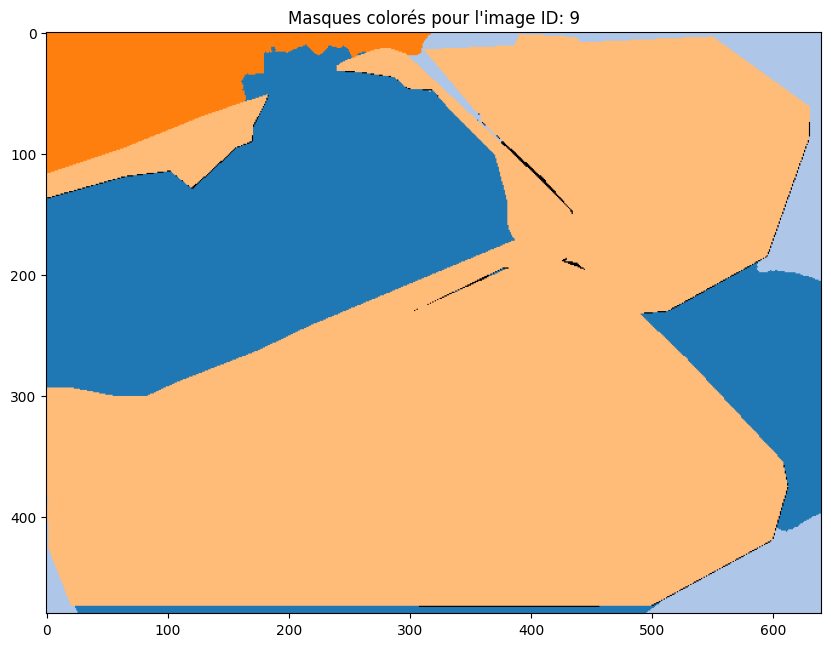

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from pycocotools import mask as maskUtils
from PIL import Image

# Charger les annotations COCO pour une image spécifique
image_id = 9  # Remplace avec l'ID de ton image
annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

# Charger l'image correspondante (facultatif, pour la visualisation)
image_info = next(img for img in coco_data['images'] if img['id'] == image_id)
image_path = f"{img_output_dir}/fold_0/{image_info['file_name']}"
image = Image.open(image_path)

# Créer une image vierge pour les masques colorés
mask_image = np.zeros((image_info['height'], image_info['width'], 3), dtype=np.uint8)

# Créer une liste de couleurs en utilisant la nouvelle syntaxe
cmap = plt.colormaps.get_cmap('tab20')
colors = [cmap(i) for i in range(len(annotations))]

# Parcourir chaque annotation pour l'image
for idx, annotation in enumerate(annotations):
    category_id = annotation['category_id']
    
    # Décoder le masque RLE
    rle = annotation['segmentation']['counts']
    size = annotation['segmentation']['size']
    mask = maskUtils.decode({'size': size, 'counts': rle})
    
    # Associer la couleur
    color = (np.array(colors[idx][:3]) * 255).astype(np.uint8)
    
    # Appliquer la couleur au masque
    for c in range(3):
        mask_image[:, :, c] += mask * color[c]

    # Afficher la catégorie pour chaque masque
    category_name = next(cat['name'] for cat in coco_data['categories'] if cat['id'] == category_id)
    print(f"Catégorie: {category_name}, ID: {category_id}, Couleur: {color}")

# Afficher l'image des masques colorés
plt.figure(figsize=(10, 10))
plt.imshow(mask_image)
plt.title(f"Masques colorés pour l'image ID: {image_id}")
plt.show()


In [24]:
import os
import numpy as np
from PIL import Image
from pycocotools import mask as maskUtils
from pycocotools.coco import COCO

# Dossier contenant les images et les masques
img_output_dir = '/home/rob/Documents/3_projects/bench/coco/output/tmp_data/imgs'
mask_dir = '/home/rob/Documents/3_projects/bench/coco/output/tmp_data/masks'  # Chemin où se trouvent les masques

# Charger les annotations COCO
annotation_file = os.path.join('/home/rob/Documents/3_projects/bench/coco/output/tmp_data', 'stuff_annotations_trainval2017', 'annotations', 'stuff_train2017.json')
coco = COCO(annotation_file)

loading annotations into memory...
Done (t=7.24s)
creating index...
index created!


In [ ]:
# Dictionnaire pour stocker la correspondance couleur -> classe
color_to_class = {}

# Parcourir toutes les images dans le fold courant
for image_info in coco.imgs.values():
    image_id = image_info['id']
    image_file = image_info['file_name']
    image_path = os.path.join(img_output_dir, image_file)
    mask_file = image_file.replace('.jpg', '.png')
    mask_path = os.path.join(mask_dir, mask_file)
    
    if not os.path.exists(image_path) or not os.path.exists(mask_path):
        print(f"Image or mask not found for {image_file}, skipping.")
        continue
    
    # Charger l'image et le masque
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert("RGB")
    
    mask_array = np.array(mask)
    
    # Récupérer les annotations pour cette image
    annotations = [ann for ann in coco.loadAnns(coco.getAnnIds(imgIds=image_id))]
    
    for annotation in annotations:
        category_id = annotation['category_id']
        
        # Décoder le masque RLE pour cette annotation
        rle = annotation['segmentation']['counts']
        size = annotation['segmentation']['size']
        decoded_mask = maskUtils.decode({'size': size, 'counts': rle})
        
        # Trouver la couleur associée à cette classe dans le masque
        unique_colors = np.unique(mask_array.reshape(-1, mask_array.shape[2]), axis=0)
        
        for color in unique_colors:
            color_tuple = tuple(color)
            
            # Vérifier et mettre à jour le dictionnaire de correspondance
            if color_tuple in color_to_class:
                if color_to_class[color_tuple] != category_id:
                    raise Exception(f"Color mismatch: color {color_tuple} mapped to class {color_to_class[color_tuple]} and {category_id}")
            else:
                if category_id in color_to_class.values():
                    existing_color = next(key for key, value in color_to_class.items() if value == category_id)
                    raise Exception(f"Class {category_id} already has a different color: {existing_color}")
                color_to_class[color_tuple] = category_id
            
            # Appliquer la couleur au masque
            mask_indices = (mask_array == color).all(axis=-1)
            for i in range(3):  # Appliquer la couleur à chaque canal
                mask_array[:, :, i][mask_indices] = decoded_mask[mask_indices] * color[i]
        
print("Dictionnaire de correspondance couleur -> classe:", color_to_class)
